In [1]:
"""
HHL Benchmark Program - QSim

"""

import sys
import time

import numpy as np
pi = np.pi

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import BasicAer, execute

import sparse_Ham_sim as shs
import uniform_controlled_rotation as ucr

from qiskit.circuit.library import QFT

# include QFT in this list, so we can refer to the QFT sub-circuit definition
#sys.path[1:1] = ["_common", "_common/qiskit", "quantum-fourier-transform/qiskit"]
#sys.path[1:1] = ["../../_common", "../../_common/qiskit", "../../quantum-fourier-transform/qiskit"]

# cannot use the QFT common yet, as HHL seems to use reverse bit order
sys.path[1:1] = ["_common", "_common/qsim", "quantum-fourier-transform/qsim"]
sys.path[1:1] = ["../../_common", "../../_common/qsim", "../../quantum-fourier-transform/qsim"]
#from qft_benchmark import qft_gate, inv_qft_gate

import execute as ex
import metrics as metrics
from execute import BenchmarkResult

# Benchmark Name
benchmark_name = "HHL"

np.random.seed(0)

verbose = False

# Variable for number of resets to perform after mid circuit measurements
num_resets = 1

# saved circuits for display
QC_ = None
U_ = None
UI_ = None
QFT_ = None
QFTI_ = None
HP_ = None
INVROT_ = None




In [2]:
############### Circuit Definitions 

''' replaced with code below ... 
def qft_dagger(qc, clock, n):      
    qc.h(clock[1]);
    for j in reversed(range(n)):
      for k in reversed(range(j+1,n)):
        qc.cu1(-np.pi/float(2**(k-j)), clock[k], clock[j]);
    qc.h(clock[0]);

def qft(qc, clock, n):
    qc.h(clock[0]);
    for j in reversed(range(n)):
      for k in reversed(range(j+1,n)):
        qc.cu1(np.pi/float(2**(k-j)), clock[k], clock[j]);
    qc.h(clock[1]);
'''

'''
DEVNOTE: the QFT and IQFT are defined here as they are in the QFT benchmark - almost;
Here, the sign of the angles is reversed and the QFT is actually used as the inverse QFT.
This is an inconsistency that needs to be resolved later. 
The QPE part of the algorithm should be using the inverse QFT, but the qubit order is not correct.
The QFT as defined in the QFT benchmark operates on qubits in the opposite order from the HHL pattern.
'''

def initialize_state(qc, qreg, b):
    """ b (int): initial basis state |b> """
    
    n = qreg.size
    b_bin = np.binary_repr(b, width=n)
    if verbose:
        print(f"... initializing |b> to {b}, binary repr = {b_bin}")
    
    for q in range(n):
        if b_bin[n-1-q] == '1':
            qc.x(qreg[q])
    
    return qc


def IQFT(qc, qreg):
    """ inverse QFT
        qc : QuantumCircuit
        qreg : QuantumRegister belonging to qc
        
        does not include SWAP at end of the circuit
    """
    
    n = int(qreg.size)
    
    for i in reversed(range(n)):
        for j in range(i+1,n): 
            phase = -pi/2**(j-i) 
            qc.cp(phase, qreg[i], qreg[j])
        qc.h(qreg[i])
    
    return qc


def QFT(qc, qreg):
    """   QFT
          qc : QuantumCircuit
        qreg : QuantumRegister belonging to qc
        
        does not include SWAP at end of circuit
    """
    
    n = int(qreg.size)
    
    for i in range(n):
        qc.h(qreg[i])
        for j in reversed(range(i+1,n)):
            phase = pi/2**(j-i)
            qc.cp(phase, qreg[i], qreg[j])
         
    return qc


def inv_qft_gate(input_size, method=1):
#def qft_gate(input_size):
    #global QFT_
    qr = QuantumRegister(input_size);
    #qc = QuantumCircuit(qr, name="qft")
    qc = QuantumCircuit(qr, name="IQFT")
    
    if method == 1:
    
        # Generate multiple groups of diminishing angle CRZs and H gate
        for i_qubit in range(0, input_size):
        
            # start laying out gates from highest order qubit (the hidx)
            hidx = input_size - i_qubit - 1
            
            # if not the highest order qubit, add multiple controlled RZs of decreasing angle
            if hidx < input_size - 1:   
                num_crzs = i_qubit
                for j in range(0, num_crzs):
                    divisor = 2 ** (num_crzs - j)
                    #qc.crz( math.pi / divisor , qr[hidx], qr[input_size - j - 1])
                    ##qc.crz( -np.pi / divisor , qr[hidx], qr[input_size - j - 1])
                    qc.cp(-np.pi / divisor, qr[hidx], qr[input_size - j - 1]);
                
            # followed by an H gate (applied to all qubits)
            qc.h(qr[hidx])
    
    elif method == 2:
        # apply IQFT to register
        for i in range(input_size)[::-1]:
            for j in range(i+1,input_size):
                phase = -np.pi/2**(j-i)
                qc.cp(phase, qr[i], qr[j])
            qc.h(qr[i])    
        
    qc.barrier()
    
    return qc

############### Inverse QFT Circuit

def qft_gate(input_size, method=1):
#def inv_qft_gate(input_size):
    #global QFTI_
    qr = QuantumRegister(input_size);
    #qc = QuantumCircuit(qr, name="inv_qft")
    qc = QuantumCircuit(qr, name="QFT")
    
    if method == 1:
        # Generate multiple groups of diminishing angle CRZs and H gate
        for i_qubit in reversed(range(0, input_size)):
        
            # start laying out gates from highest order qubit (the hidx)
            hidx = input_size - i_qubit - 1
            
            # precede with an H gate (applied to all qubits)
            qc.h(qr[hidx])
            
            # if not the highest order qubit, add multiple controlled RZs of decreasing angle
            if hidx < input_size - 1:   
                num_crzs = i_qubit
                for j in reversed(range(0, num_crzs)):
                    divisor = 2 ** (num_crzs - j)
                    #qc.crz( -math.pi / divisor , qr[hidx], qr[input_size - j - 1])
                    ##qc.crz( np.pi / divisor , qr[hidx], qr[input_size - j - 1])
                    qc.cp( np.pi / divisor , qr[hidx], qr[input_size - j - 1])
    
    elif method == 2:
        # apply QFT to register
        for i in range(input_size):
            qc.h(qr[i])
            for j in range(i+1, input_size):
                phase = np.pi/2**(j-i)
                qc.cp(phase, qr[i], qr[j])
                
    qc.barrier()

    return qc

 
############# Controlled U Gate

#Construct the U gates for A
def ctrl_u(exponent):

    qc = QuantumCircuit(1, name=f"U^{exponent}")
    
    for i in range(exponent):
        #qc.u(np.pi/2, -np.pi/2, np.pi/2, 3*np.pi/4, target);
        #qc.cu(np.pi/2, -np.pi/2, np.pi/2, 3*np.pi/4, control, target);
        qc.u(np.pi/2, -np.pi/2, np.pi/2, 0);
    
    cu_gate = qc.to_gate().control(1)

    return cu_gate, qc

#Construct the U^-1 gates for reversing A
def ctrl_ui(exponent):

    qc = QuantumCircuit(1, name=f"U^-{exponent}")
    
    for i in range(exponent):
        #qc.u(np.pi/2, -np.pi/2, np.pi/2, 3*np.pi/4, target);
        #qc.cu(np.pi/2, -np.pi/2, np.pi/2, 3*np.pi/4, control, target);
        qc.u(np.pi/2, np.pi/2, -np.pi/2, 0);
    
    cu_gate = qc.to_gate().control(1)

    return cu_gate, qc


In [3]:
####### DEVNOTE: The following functions (up until the make_circuit) are from the first inccarnation
#       of this benchmark and are not used here.  Should be removed, but kept here for reference for now


############# Quantum Phase Estimation
   
# DEVNOTE: The QPE and IQPE methods below mirror the mechanism in Hector_Wong
# Need to investigate whether the clock qubits are in the correct, as this implementation
# seems to require the QFT be implemented in reverse also.  TODO

# Append a series of Quantum Phase Estimation gates to the circuit   
def qpe(qc, clock, target, extra_qubits=None, ancilla=None, A=None, method=1):
    qc.barrier()

    ''' original code from Hector_Wong 
    # e^{i*A*t}
    #qc.cu(np.pi/2, -np.pi/2, np.pi/2, 3*np.pi/4, clock[0], target, label='U');
    
    # The CU gate is equivalent to a CU1 on the control bit followed by a CU3
    qc.u1(3*np.pi/4, clock[0]);
    qc.cu3(np.pi/2, -np.pi/2, np.pi/2, clock[0], target);
    
    # e^{i*A*t*2}
    #qc.cu(np.pi, np.pi, 0, 0, clock[1], target, label='U2');
    qc.cu3(np.pi, np.pi, 0, clock[1], target);
    
    qc.barrier();
    '''

    # apply series of controlled U operations to the state |1>
    # does nothing to state |0> 
    # DEVNOTE: have not found a way to create a controlled operation that contains a U gate 
    # with the global phase; instead do it piecemeal for now
    
    if method == 1:
    
        repeat = 1
        #for j in reversed(range(len(clock))):
        for j in (range(len(clock))):
    
            # create U with exponent of 1, but in a loop repeating N times
            for k in range(repeat):
            
                # this global phase is applied to clock qubit
                qc.u1(3*np.pi/4, clock[j]);
                
                # apply the rest of U controlled by clock qubit
                #cp, _ = ctrl_u(repeat)
                cp, _ = ctrl_u(1)
                qc.append(cp, [clock[j], target])  
            
            repeat *= 2
            
            qc.barrier();
    
        #Define global U operator as the phase operator (for printing later)
        _, U_ = ctrl_u(1)
        
        
    if method == 2:
        
        for j in range(len(clock)):
            
            control = clock[j]
            phase = -(2*np.pi)*2**j
            con_H_sim = shs.control_Ham_sim(A, phase)
            qubits = [control] + [q for q in target] + [q for q in extra_qubits] + [ancilla[0]]
            qc.append(con_H_sim, qubits)
    
    # Perform an inverse QFT on the register holding the eigenvalues
    qc.append(inv_qft_gate(len(clock), method), clock)
            

# Append a series of Inverse Quantum Phase Estimation gates to the circuit    
def inv_qpe(qc, clock, target, extra_qubits=None, ancilla=None, A=None, method=1):
    
    # Perform a QFT on the register holding the eigenvalues
    qc.append(qft_gate(len(clock), method), clock)
    
    qc.barrier()
    
    if method == 1:
    
        ''' original code from Hector_Wong 
        # e^{i*A*t*2}
        #qc.cu(np.pi, np.pi, 0, 0, clock[1], target, label='U2');
        qc.cu3(np.pi, np.pi, 0, clock[1], target);
    
        # e^{i*A*t}
        #qc.cu(np.pi/2, np.pi/2, -np.pi/2, -3*np.pi/4, clock[0], target, label='U');
        # The CU gate is equivalent to a CU1 on the control bit followed by a CU3
        qc.u1(-3*np.pi/4, clock[0]);
        qc.cu3(np.pi/2, np.pi/2, -np.pi/2, clock[0], target);
    
        qc.barrier()
        '''
        
        # apply inverse series of controlled U operations to the state |1>
        # does nothing to state |0> 
        # DEVNOTE: have not found a way to create a controlled operation that contains a U gate 
        # with the global phase; instead do it piecemeal for now
        
        repeat = 2 ** (len(clock) - 1)
        for j in reversed(range(len(clock))):
        #for j in (range(len(clock))):
    
            # create U with exponent of 1, but in a loop repeating N times
            for k in range(repeat):
    
                # this global phase is applied to clock qubit
                qc.u1(-3*np.pi/4, clock[j]);
                
                # apply the rest of U controlled by clock qubit
                #cp, _ = ctrl_u(repeat)
                cp, _ = ctrl_ui(1)
                qc.append(cp, [clock[j], target])  
            
            repeat = int(repeat / 2)
            
            qc.barrier();
    
        #Define global U operator as the phase operator (for printing later)
        _, UI_ = ctrl_ui(1)
    
    if method == 2:
        
        for j in reversed(range(len(clock))):
            
            control = clock[j]
            phase = (2*np.pi)*2**j
            con_H_sim = shs.control_Ham_sim(A, phase)
            qubits = [control] + [q for q in target] + [q for q in extra_qubits] + [ancilla[0]]
            qc.append(con_H_sim, qubits)
    

In [4]:

############### Make HHL Circuit

# Make the HHL circuit 
def make_circuit(A, b, num_clock_qubits):
    """ Generate top-level circuit for HHL algo A|x>=|b>
    
        A : sparse Hermitian matrix
        b (int): between 0,...,2^n-1. Initial basis state |b>
    """
    
    # save smaller circuit example for display
    global QC_, U_, UI_, QFT_, QFTI_, HP_, INVROT_

    # read in number of qubits
    N = len(A)
    n = int(np.log2(N))
    n_t = num_clock_qubits # number of qubits in clock register
    
    num_qubits = 2*n + n_t + 1
    
    # lower bound on eigenvalues of A. Fixed for now
    C = 1/4
    
    ''' Define sets of qubits for this algorithm '''
    
    # create 'input' quantum and classical measurement register
    qr = QuantumRegister(n, name='input')
    qr_b = QuantumRegister(n, name='in_anc') # ancillas for Hamiltonian simulation (?)
    cr = ClassicalRegister(n)
    
    # create 'clock' quantum register
    qr_t = QuantumRegister(n_t, name='clock') # for phase estimation
    
    # create 'ancilla' quantum and classical measurement register
    qr_a = QuantumRegister(1, name='ancilla') # ancilla qubit
    cr_a = ClassicalRegister(1)
    
    # create the top-level HHL circuit, with all the registers
    qc = QuantumCircuit(qr, qr_b, qr_t, qr_a, cr, cr_a, name=f"hhl-{num_qubits}-{b}")

    ''' Initialize the input and clock qubits '''
    
    # initialize the |b> state - the 'input'
    qc = initialize_state(qc, qr, b)
    
    #qc.barrier()

    # Hadamard the phase estimation register - the 'clock'
    for q in range(n_t):
        qc.h(qr_t[q])

    qc.barrier()
     
    ''' Perform Quantum Phase Estimation on input (b), clock, and ancilla '''
    
    # perform controlled e^(i*A*t)
    for q in range(n_t):
        control = qr_t[q]
        anc = qr_a[0]
        phase = -(2*pi)*2**q  
        qc_u = shs.control_Ham_sim(n, A, phase)
        if phase <= 0:
            qc_u.name = "e^{" + str(q) + "iAt}"
        else:
            qc_u.name = "e^{-" + str(q) + "iAt}"
        if U_ == None:
            U_ = qc_u
        qc.append(qc_u, qr[0:len(qr)] + qr_b[0:len(qr_b)] + [control] + [anc])

    qc.barrier()
    
    ''' Perform Inverse Quantum Fourier Transform on clock qubits '''
    
    #qc = IQFT(qc, qr_t)
    
    qc_qfti = inv_qft_gate(n_t, method=2)
    qc.append(qc_qfti, qr_t)

    if QFTI_ == None:
        QFTI_ = qc_qfti
    
    qc.barrier()
    
    ''' Perform inverse rotation with ancilla '''
    
    # reset ancilla
    qc.reset(qr_a[0])
    
    # compute angles for inversion rotations
    alpha = [2*np.arcsin(C)]
    for x in range(1,2**n_t):
        x_bin_rev = np.binary_repr(x, width=n_t)[::-1]
        lam = int(x_bin_rev,2)/(2**n_t)
        if lam < C:
            alpha.append(0)
        elif lam >= C:
            alpha.append(2*np.arcsin(C/lam))
    theta = ucr.alpha2theta(alpha)
        
    # do inversion step

    qc_invrot = ucr.uniformly_controlled_rot(n_t, theta)
    qc.append(qc_invrot, qr_t[0:len(qr_t)] + [qr_a[0]])
    
    if INVROT_ == None:
        INVROT_ = qc_invrot
    
    # and measure ancilla
    
    qc.measure(qr_a[0], cr_a[0])#, basis = "Ensemble", add_param = "Z")
    qc.reset(qr_a[0])

    qc.barrier()
    
    ''' Perform Quantum Fourier Transform on clock qubits '''
   
    #qc = QFT(qc, qr_t)
    
    qc_qft = qft_gate(n_t, method=2)
    qc.append(qc_qft, qr_t)

    if QFT_ == None:
        QFT_ = qc_qft
    
    qc.barrier()
    
    ''' Perform Inverse Quantum Phase Estimation on input (b), clock, and ancilla '''
    
    # uncompute phase estimation
    # perform controlled e^(-i*A*t)
    for q in reversed(range(n_t)):
        control = qr_t[q]
        phase = (2*pi)*2**q  
        qc_ui = shs.control_Ham_sim(n, A, phase)
        if phase <= 0:
            qc_ui.name = "e^{" + str(q) + "iAt}"
        else:
            qc_ui.name = "e^{-" + str(q) + "iAt}"
        if UI_ == None:
            UI_ = qc_ui
        qc.append(qc_ui, qr[0:len(qr)] + qr_b[0:len(qr_b)] + [control] + [anc])

    qc.barrier()
    
    # Hadamard (again) the phase estimation register - the 'clock'
    for q in range(n_t):
        qc.h(qr_t[q])
    
    qc.barrier()
    
    ''' Perform final measurements '''
    
    # measure ancilla and main register
    qc.measure(qr[0:], cr[0:])#, basis = "Ensemble", add_param = "Z")

    if QC_ == None:
        QC_ = qc
        #print(f"... made circuit = \n{QC_}")

    return qc


In [5]:
 
############### Result Data Analysis

saved_result = None

# Compute the expected distribution, given the matrix A and input value b
def true_distr(A, b=0):
    
    N = len(A)
    n = int(np.log2(N))
    b_vec = np.zeros(N); b_vec[b] = 1.0
    #b = np.array([1,1])/np.sqrt(2)
    
    x = np.linalg.inv(A) @ b_vec
    # normalize x
    x_n = x/np.linalg.norm(x)
    probs = np.array([np.abs(xj)**2 for xj in x_n])
    
    distr = {}
    for j, prob in enumerate(probs):
        if prob > 1e-8:
            j_bin = np.binary_repr(j, width=n)
            distr[j_bin] = prob
    
    distr = {out:distr[out]/sum(distr.values()) for out in distr}
    
    return distr

#  # post-select counts where ancilla was measured as |1>
# def postselect(outcomes, return_probs=True):
    
#     mar_out = {}
#     for b_str in outcomes:
#         if b_str[0] == '1':
#             counts = outcomes[b_str]
#             mar_out[b_str[2:]] = counts
#             # print(f"mar_out[b_str[2:]] ===== {mar_out[b_str[2:]]}")

#     print(f"mar_out ================================================== {mar_out}")
        
#     # compute postselection rate
#     ps_shots = sum(mar_out.values())
#     print(f"ps_shots ===== {ps_shots}")
    
#     shots = sum(outcomes.values())
#     print(f"shots ===== {shots}")

#     rate = ps_shots/shots
    
#     # convert to probability distribution
#     if return_probs == True:
#         mar_out = {b_str:round(mar_out[b_str]/ps_shots, 4) for b_str in mar_out}  
    
#     return mar_out, rate

def postselect(outcomes, return_probs=True):
    mar_out = {}
    
    # Filter outcomes based on the condition
    for b_str in outcomes:
        if b_str and b_str[0] == '1':  # Check if b_str is not empty and starts with '1'
            counts = outcomes[b_str]
            mar_out[b_str[:]] = counts

    # print(f"mar_out ================================================== {mar_out}")
        
    # Compute postselection rate
    ps_shots = sum(mar_out.values())
    # print(f"ps_shots ================================================== {ps_shots}")
    
    shots = sum(outcomes.values())
    # print(f"shots ================================================== {shots}")

    rate = ps_shots / shots
    
    # Convert to probability distribution
    if return_probs:
        mar_out = {b_str: round(mar_out[b_str] / ps_shots, 4) for b_str in mar_out if ps_shots != 0}  # Avoid division by zero

    return mar_out, rate


In [6]:
    
# Analyze the quality of the result obtained from executing circuit qc 
def analyze_and_print_result (qc, result, num_qubits, s_int, num_shots):
    
    global saved_result
    saved_result = result
    # print(result)
    if result.backend_name == 'dm_simulator':
        benchmark_result = BenchmarkResult(result, num_shots)
        probs = benchmark_result.get_probs(num_shots)        # get results as measured probability
    else:
        probs = result.get_counts(qc)    # get results as measured counts
        
    if verbose:
        print(f"... for circuit = {num_qubits} {s_int}, probability = {probs}")

    # print(f"probs ================================================== {probs}")

    # post-select counts where ancilla was measured as |1>
    post_probs, rate = postselect(probs)
    # print(f"post_probs ================================================== {post_probs}")
    num_input_qubits = len(list(post_probs.keys())[0])
    
    if verbose: 
        print(f'... ratio of counts with ancilla measured |1> : {round(rate, 4)}')
    
    # compute true distribution from secret int
    off_diag_index = 0
    b = 0
    
    # remove instance index from s_int
    s_int = s_int - 1000 * int(s_int/1000)
    
    # get off_diag_index and b
    s_int_o = int(s_int)
    s_int_b = int(s_int)   
    
    while (s_int_o % 2) == 0:
        s_int_o = int(s_int_o/2)
        off_diag_index += 1
        
    while (s_int_b % 3) == 0:
        s_int_b = int(s_int_b/3)
        b += 1
    
    if verbose:
        print(f"... rem(s_int) = {s_int}, b = {b}, odi = {off_diag_index}")
        
    # temporarily fix diag and off-diag matrix elements
    diag_el = 0.5
    off_diag_el = -0.25
    A = shs.generate_sparse_H(num_input_qubits, off_diag_index,
                              diag_el=diag_el, off_diag_el=off_diag_el)
    ideal_distr = true_distr(A, b)
    # print(f"ideal_distr ================================================== {ideal_distr}")

    # # compute total variation distance
    # tvd = TVD(ideal_distr, post_probs)
    
    # # use TVD as infidelity
    # fidelity = 1 - tvd
    # #fidelity = metrics.polarization_fidelity(post_probs, ideal_distr)

    # fidelity = metrics.polarization_fidelity(post_probs, ideal_distr)

    def reverse_dict_keys(d):
        return {k[::-1]: v for k, v in d.items()}

    reversed_ideal_distr = reverse_dict_keys(ideal_distr)
    # print("Reversed ideal distribution ================================================== ", reversed_ideal_distr)
    fidelity = metrics.polarization_fidelity(post_probs, reversed_ideal_distr)
    
    # print(f"fidelity ================================================== {fidelity}")
    
    return post_probs, fidelity


In [7]:

################ Benchmark Loop

# Execute program with default parameters (based on min and max_qubits)
# This routine computes a reasonable min and max input and clock qubit range to sweep
# from the given min and max qubit sizes using the formula below and making the 
# assumption that num_input_qubits ~= num_clock_qubits and num_input_qubits < num_clock_qubits:
#      num_qubits = 2 * num_input_qubits + num_clock_qubits + 1 (the ancilla)

def run (min_qubits=8, max_qubits=10, skip_qubits=1, max_circuits=3, num_shots=100,        # min_qubits=8 because partial_probability not getting below 8 qubits
        method = 1, use_best_widths=True,
        backend_id='dm_simulator', provider_backend=None,
        #hub="ibm-q", group="open", project="main", 
        exec_options=None,
        context=None):  

    # we must have at least 4 qubits and min must be less than max
    max_qubits = max(4, max_qubits)
    min_qubits = min(max(4, min_qubits), max_qubits)
    skip_qubits = max(1, skip_qubits)
    #print(f"... using min_qubits = {min_qubits} and max_qubits = {max_qubits}")

    # create context identifier
    if context is None: context = f"{benchmark_name} Benchmark"
    
    ''' first attempt ..
    min_input_qubits = min_qubits//2
    if min_qubits%2 == 1:
        min_clock_qubits = min_qubits//2 + 1
    else:
        min_clock_qubits = min_qubits//2

    max_input_qubits = max_qubits//2
    if max_qubits%2 == 1:
        max_clock_qubits = max_qubits//2 + 1
    else:
        max_clock_qubits = max_qubits//2
    '''
    
    # the calculation below is based on the formula described above, where I = input, C = clock:
    
    # I = int((N - 1) / 3)
    min_input_qubits = int((min_qubits - 1) / 3)
    max_input_qubits = int((max_qubits - 1) / 3)
    
    # C = N - 1 - 2 * I
    min_clock_qubits = min_qubits - 1 - 2 * min_input_qubits
    max_clock_qubits = max_qubits - 1 - 2 * max_input_qubits
    
    #print(f"... input, clock qubit width range: {min_input_qubits} : {max_input_qubits}, {min_clock_qubits} : {max_clock_qubits}")

    return run2(min_input_qubits=min_input_qubits,max_input_qubits= max_input_qubits,
            min_clock_qubits=min_clock_qubits, max_clock_qubits=max_clock_qubits,
            skip_qubits=skip_qubits,
            max_circuits=max_circuits, num_shots=num_shots, 
            method=method, use_best_widths=use_best_widths,
            backend_id=backend_id, provider_backend=provider_backend,
           # hub=hub, group=group, project=project, 
            exec_options=exec_options,
            context=context)


In [8]:
# Execute program with default parameters and permitting the user to specify an
# arbitrary range of input and clock qubit widths
# The benchmark sweeps over all input widths and clock widths in the range specified

def run2 (min_input_qubits=1, max_input_qubits=5, skip_qubits=1,
        min_clock_qubits=1, max_clock_qubits=5,
        max_circuits=3, num_shots=100,
        method=2, use_best_widths=False,
        backend_id='dm_simulator', provider_backend=None,
      #  hub="ibm-q", group="open", project="main", 
        exec_options=None,
        context=None):  
    
    print(f"{benchmark_name} Benchmark Program - QSim")

    # ensure valid input an clock qubit widths
    min_input_qubits = min(max(1, min_input_qubits), max_input_qubits)
    max_input_qubits = max(min_input_qubits, max_input_qubits)
    min_clock_qubits = min(max(1, min_clock_qubits), max_clock_qubits)
    max_clock_qubits = max(min_clock_qubits, max_clock_qubits)
    #print(f"... in, clock: {min_input_qubits}, {max_input_qubits}, {min_clock_qubits}, {max_clock_qubits}")
    
    # initialize saved circuits for display
    global QC_, U_, UI_, QFT_, QFTI_, HP_, INVROT_
    QC_ = None
    U_ = None
    UI_ = None
    QFT_ = None
    QFTI_ = None
    HP_ = None
    INVROT_ = None

    ##########
    
    # Initialize metrics module
    metrics.init_metrics()

    # Define custom result handler
    def execution_handler(qc, result, num_qubits, s_int, num_shots):
     
        # determine fidelity of result set
        num_qubits = int(num_qubits)
        
        #counts, fidelity = analyze_and_print_result(qc, result, num_qubits, ideal_distr)
        counts, fidelity = analyze_and_print_result(qc, result, num_qubits, int(s_int), num_shots)
        metrics.store_metric(num_qubits, s_int, 'fidelity', fidelity)
    
    # Variable for new qubit group ordering if using mid_circuit measurements
    mid_circuit_qubit_group = []

    # If using mid_circuit measurements, set transform qubit group to true
    transform_qubit_group = False
    
    # Initialize execution module using the execution result handler above and specified backend_id
    ex.init_execution(execution_handler)
    ex.set_execution_target(backend_id, provider_backend=provider_backend,
           # hub=hub, group=group, project=project, 
            exec_options=exec_options,
            context=context)

    # for noiseless simulation, set noise model to be None
    #ex.set_noise_model(None)
    
    # temporarily fix diag and off-diag matrix elements
    diag_el = 0.5
    off_diag_el = -0.25
    
    ##########
    
    # Execute Benchmark Program N times for multiple circuit sizes
    # Accumulate metrics asynchronously as circuits complete
    #for num_input_qubits in range(min_input_qubits, max_input_qubits+1):
    for num_input_qubits in range(min_input_qubits, max_input_qubits + 1, skip_qubits):
        N = 2**num_input_qubits # matrix size
                    
        for num_clock_qubits in range(min_clock_qubits, max_clock_qubits+1, skip_qubits):      
            num_qubits = 2*num_input_qubits + num_clock_qubits + 1
        
            # determine number of circuits to execute for this group
            num_circuits = max_circuits

            # if flagged to use best input and clock for specific num_qubits, check against formula
            if use_best_widths:
                if num_input_qubits != int((num_qubits - 1) / 3) or num_clock_qubits != (num_qubits - 1 - 2 * num_input_qubits):
                
                    if verbose:   
                        print(f"... SKIPPING {num_circuits} circuits with {num_qubits} qubits, using {num_input_qubits} input qubits and {num_clock_qubits} clock qubits")
                    continue
                    
            print(f"************\nExecuting {num_circuits} circuits with {num_qubits} qubits, using {num_input_qubits} input qubits and {num_clock_qubits} clock qubits")
            
            # loop over randomly generated problem instances
            for i in range(num_circuits):

                # generate a non-zero value < N
                #b = np.random.choice(range(N))           # orig code, gens 0 sometimes
                b = np.random.choice(range(1, N))
                
                # and a non-zero index
                off_diag_index = np.random.choice(range(1, N))
                
                # define secret_int (include 'i' since b and off_diag_index don't need to be unique)
                s_int = 1000 * (i+1) + (2**off_diag_index)*(3**b)
                #s_int = (2**off_diag_index)*(3**b)

                if verbose:
                    print(f"... create A for b = {b}, off_diag_index = {off_diag_index}, s_int = {s_int}")
                
                A = shs.generate_sparse_H(num_input_qubits, off_diag_index,
                                          diag_el=diag_el, off_diag_el=off_diag_el)             
                
                # create the circuit for given qubit size and secret string, store time metric
                ts = time.time()
                qc = make_circuit(A, b, num_clock_qubits)
                metrics.store_metric(num_qubits, s_int, 'create_time', time.time()-ts)
                
                # print(qc)
                
                # submit circuit for execution on target (simulator, cloud simulator, or hardware)
                ex.submit_circuit(qc, num_qubits, s_int, shots=num_shots)
        
            # Wait for some active circuits to complete; report metrics when groups complete
            ex.throttle_execution(metrics.finalize_group)
        
    # Wait for all active circuits to complete; report metrics when groups complete
    ex.finalize_execution(metrics.finalize_group)

    ##########
    
    # print a sample circuit
    print("Sample Circuit:"); print(QC_ if QC_ != None else "  ... too large!")
    #if method == 1: print("\nQuantum Oracle 'Uf' ="); print(Uf_ if Uf_ != None else " ... too large!")
    print("\nU Circuit ="); print(U_ if U_ != None else "  ... too large!")
    print("\nU^-1 Circuit ="); print(UI_ if UI_ != None else "  ... too large!")
    print("\nQFT Circuit ="); print(QFT_ if QFT_ != None else "  ... too large!")
    print("\nInverse QFT Circuit ="); print(QFTI_ if QFTI_ != None else "  ... too large!")
    print("\nHamiltonian Phase Estimation Circuit ="); print(HP_ if HP_ != None else "  ... too large!")
    print("\nControlled Rotation Circuit ="); print(INVROT_ if INVROT_ != None else "  ... too large!")

    # Plot metrics for all circuit sizes
    metrics.plot_metrics(f"Benchmark Results - {benchmark_name} - QSim",
                         transform_qubit_group = transform_qubit_group, new_qubit_group = mid_circuit_qubit_group)



HHL Benchmark Program - QSim
... execution starting at Mar 27, 2024 12:46:15 UTC
DM_SIMULATOR
************
Executing 3 circuits with 8 qubits, using 2 input qubits and 3 clock qubits
          ┌───┐ ░ ┌───────────┐┌───────────┐┌───────────┐ ░           ░      »
 input_0: ┤ X ├─░─┤0          ├┤0          ├┤0          ├─░───────────░──────»
          └───┘ ░ │           ││           ││           │ ░           ░      »
 input_1: ──────░─┤1          ├┤1          ├┤1          ├─░───────────░──────»
                ░ │           ││           ││           │ ░           ░      »
in_anc_0: ──────░─┤2          ├┤2          ├┤2          ├─░───────────░──────»
                ░ │           ││           ││           │ ░           ░      »
in_anc_1: ──────░─┤3          ├┤3          ├┤3          ├─░───────────░──────»
          ┌───┐ ░ │  e^{0iAt} ││  e^{1iAt} ││  e^{2iAt} │ ░ ┌───────┐ ░      »
 clock_0: ┤ H ├─░─┤4          ├┤           ├┤           ├─░─┤0      ├─░──────»
          ├───┤ ░ │        

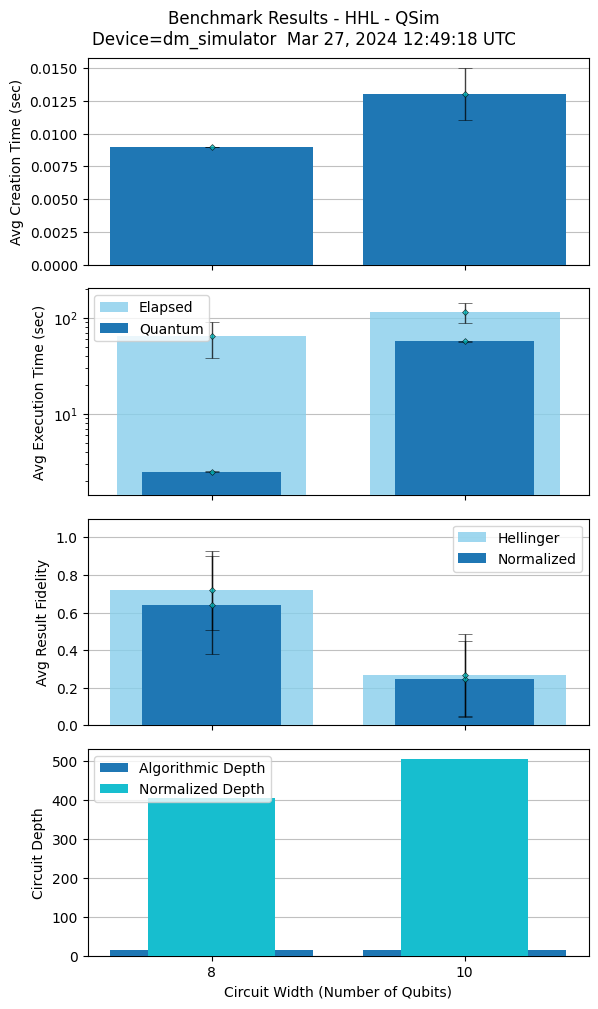

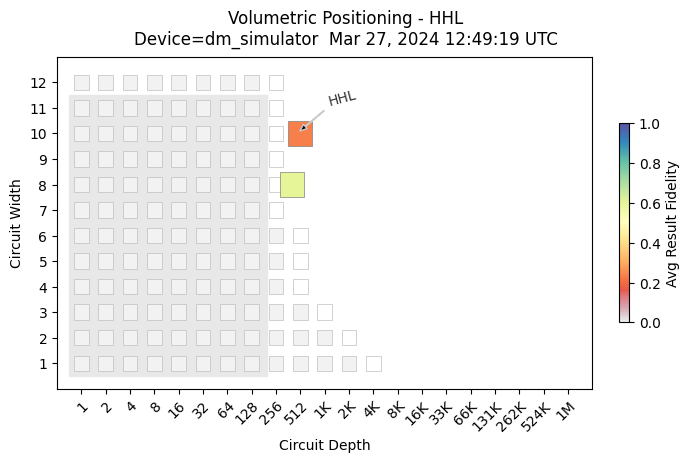

In [9]:
# if main, execute method
if __name__ == '__main__': run()